In [108]:
# !export OPENAI_API_KEY="sk-L1XFMvcUKBdPxoV6TH3QDQ"  
from openai import OpenAI
import base64
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import boto3
from MMObject.utls import *
from tqdm import tqdm

In [109]:
# def encode_image(image_path):
#   with open(image_path, "rb") as image_file:
#     return base64.b64encode(image_file.read()).decode('utf-8')
  

# img_path = "/home/ubuntu/project/11777-nxt/example_img/002877-R1-008-2A.jpg"
# base64_image = encode_image(img_path)

In [111]:

def upload_to_s3(image_path, bucket_name, object_name):
    s3_client = boto3.client(
        service_name='s3',
        region_name=,
        aws_access_key_id=,
        aws_secret_access_key=
    )
    try:
        # Add ExtraArgs to set the ACL to public-read
        s3_client.upload_file(
            image_path, 
            bucket_name, 
            object_name, 
            ExtraArgs={'ACL': 'public-read'}
        )
        url = f"https://{bucket_name}.s3.amazonaws.com/{object_name}"
        return url
    except Exception as e:
        print(f"Error uploading to S3: {e}")

# # Upload image and get URL
# image_url = upload_to_s3("../example_img/002877-R1-012-4A.jpg", 'vimaimage', 'train-aokvqa-img/my-imageee33.png')
# print(f"S3 Image URL: {image_url}")


In [113]:


def chat(image_url, prompt, api_key = "sk-L1XFMvcUKBdPxoV6TH3QDQ"):
    client = OpenAI(
      api_key = api_key,
      base_url="https://cmu.litellm.ai",
  )

    response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
          {
            "type": "image_url",
            "image_url": {
              "url": image_url,
            },
          },
        ],
      }
    ],
    max_tokens=300,
  )

    return response

In [114]:
train_aokvqa = prepare_dataset(split="train")

In [115]:
res = []

for i in trange(3):
    sample = train_aokvqa[i]
    prompt = f"""
    Your task is to provide a good rationale for the multiple choices question asked by the user based on the image provided. The correct answer to the question will be provided. The template for the rationale is as follows:

    Question: What is in the motorcyclist's mouth?
    Choices: 0. toothpick 1. food 2. popsicle stick 3. cigarette
    Correct Answer: cigarette
    Rationale: Looking at the picture, we can see a man with white shirt riding a motorcycle. Now as we find the motorcyclist in the question, we can see that he has a cigarette in his mouth.

    Question: Which number birthday is probably being celebrated?
    Choices: 0. one 1. ten 2. nine 3. thirty
    Correct Answer: thirty
    Rationale: From the question, we know that someone is celebrating for the birthday. Looking at the picture, we can see two things on the table top. One is a grey bear which is likely to be a cake, the other is a cake with several candles on it. By looking at the purple cake, we can see it writes number thirty on it.

    Question: What best describes the pool of water?
    Choices: 0. frozen 1. fresh 2. dirty 3. boiling
    Correct Answer: dirty
    Rationale: Looking at the picture, we can see a tree in the middle. Behind the tree, we can see several giraffes. On the bottom of the picture, we can see a pool of water. This refers to the pool mentioned in the question. The pool is dark brown and it is brown and surrounded with mud. So the pool is dirty.

    Now, please provide a rationale for the following question based on the image provided:
    Question: {sample['question']}
    Choices: {[f"{ind}. {choice}" for ind, choice in enumerate(sample['choices'])]}
    Correct Answer: {sample['choices'][sample['correct_choice_idx']]}
    Rationale:
    """

    split = sample["split"]
    base_path = f"/home/ubuntu/data/coco/{split}2017/"
    img_id = sample["image_id"]
    img_file = f"{str(img_id).zfill(12)}.jpg"

    img_path = base_path + img_file

    img_url = upload_to_s3(img_path, 'vimaimage', 'train-aokvqa-img/img_file')
    response = chat(img_url, prompt)
    content  = response.choices[0].message.content
    sample['gpt_ratioanle'] = content
    res.append(sample)



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


In [116]:
with open(f"/home/ubuntu/data/aokvqa/aokvqa_{split}_gpt_ratioanle.json", "w") as f:
    json.dump(res, f)

In [117]:
with open(f"/home/ubuntu/data/aokvqa/aokvqa_{split}_gpt_ratioanle.json", "r") as f:
    data = json.load(f)

In [118]:
data[1]

{'split': 'train',
 'image_id': 39446,
 'question_id': '22ZAvqke8EhGDj8e4eyios',
 'question': 'Where does this man eat pizza?',
 'choices': ['office', 'cafe', 'motel', 'outside'],
 'correct_choice_idx': 0,
 'direct_answers': ['work',
  'office',
  'work',
  'work',
  'at work',
  'desk',
  'at desk',
  'office',
  'work desk',
  'office'],
 'difficult_direct_answer': False,
 'rationales': ['The man is eating pizza at a work desk in an office setting.',
  'The man is near a computer keyboard.',
  'The man is sitting at an office desk at his job and eating his pizza.'],
 'gpt_ratioanle': 'Looking at the picture, we can see a man holding a plate with a slice of pizza. The setting resembles an office environment with cubicle walls, a computer keyboard, and various office-related items visible. This indicates that the man is eating pizza in an office.'}

In [119]:
print(response.choices[0].message.content)

Rationale: Looking at the picture, we can see a person driving a vehicle on a large field. The field is filled with sheep, which suggests this is an agricultural or livestock setting. The presence of sheep and the type of terrain strongly indicate the land is being used for farming purposes. Therefore, the best occupation for the person driving the vehicle is a farmer.


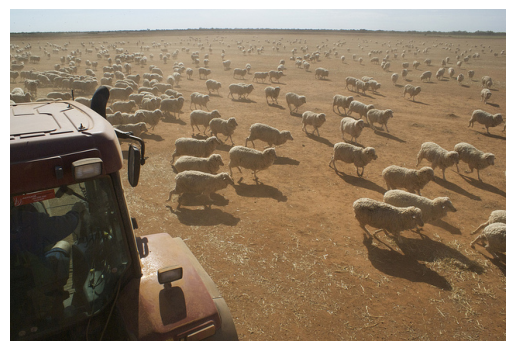

In [120]:
show_image(img_path)

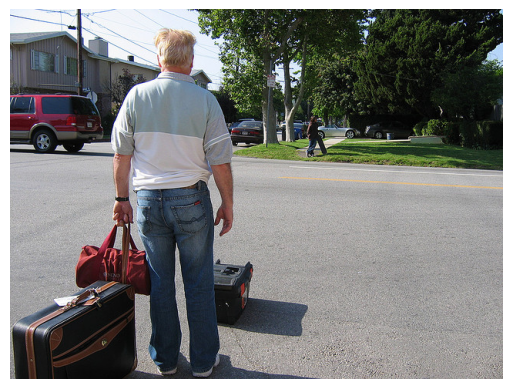

Question: What is the man by the bags awaiting?
Choices: 0. skateboarder 1. train 2. delivery 3. cab
Correct Answer: cab
Direct Answers: ['ride', 'ride', 'bus', 'taxi', 'travelling', 'traffic', 'taxi', 'cab', 'cab', 'his ride']
Rationale: ['A train would not be on the street, he would not have luggage waiting for a delivery, and the skateboarder is there and not paying attention to him so a cab is the only possible answer.', 'He has bags as if he is going someone, and he is on a road waiting for vehicle that can only be moved on the road and is big enough to hold the bags.', 'He looks to be waiting for a paid ride to pick him up.']


In [64]:
demonstrate_example(sample)

In [80]:
split = "val"
aokvqa_split = f"/home/ubuntu/data/aokvqa/aokvqa_v1p0_{split}.json"

with open(aokvqa_split, 'r') as f:
    val_aokvqa = json.load(f)

In [81]:
val_aokvqa

[{'split': 'val',
  'image_id': 461751,
  'question_id': '22jbM6gDxdaMaunuzgrsBB',
  'question': "What is in the motorcyclist's mouth?",
  'choices': ['toothpick', 'food', 'popsicle stick', 'cigarette'],
  'correct_choice_idx': 3,
  'direct_answers': ['cigarette',
   'cigarette',
   'cigarette',
   'cigarette',
   'cigarette',
   'cigarette',
   'cigarette',
   'cigarette',
   'cigarette',
   'cigarette'],
  'difficult_direct_answer': False,
  'rationales': ["He's smoking while riding.",
   'The motorcyclist has a lit cigarette in his mouth while he rides on the street.',
   'The man is smoking.']},
 {'split': 'val',
  'image_id': 377368,
  'question_id': '2Aq5RiEn7eyfWjEbpuYT2o',
  'question': 'Which number birthday is probably being celebrated?',
  'choices': ['one', 'ten', 'nine', 'thirty'],
  'correct_choice_idx': 3,
  'direct_answers': ['thirty',
   '30th',
   'thirty',
   'thirty',
   'thirty',
   '30th',
   'thirty',
   'thirty',
   'thirty',
   'thirty'],
  'difficult_direct_an